# 1.Introduction and Problem Statement


Stack Overflow is a well-knwn collaboratively edited question & answer website mainly focused on computer programming topics. Each post on Stack Overflow can be upvoted, downvoted, and favorited, and these feedback metrics give us an opportunity to run analysis of the users behavior. I was interested in looking for useful patterns in the data and answer the following questions:

<br> **1- Is there any corrolation between the score of a psot and the number of times it was favorited by the users?
<br>2- Do the users with the highest reputation mainly post answers? or do they mainly post question posts?
<br>3- Does the first question posted by users indicate their future behavior?
<br>4- Could natural language processing be used to predict the tags of a question from its body text?**

In this project, PySpark was utilized to perform data manipulation, analysis and machine learning on Stack Overflow posts. Spark is a distributed-computing framework, which provides a fast and general engine for large-scale data processing.

## 1.1. Data set

Stack Exchange provides an anonymized [data dump](https://archive.org/details/stackexchange). The data set includes information about posts, users, and vote on posts. The raw data contains more than 212,000 posts in XML format which need to be parsed efficiently. To this aim, ElementTree library in python was utilized to develop functions for parsing the XMLs and extracting the target elements from raw XML data. These functions were mapped into the raw data to create RDDs and leverage the disctrubited computing power of spark.

## 1.2. Importing libraries

In [38]:
import numpy as np
from lxml import etree
import matplotlib.pyplot as plt
from pyspark import SparkContext
from datetime import datetime
from itertools import groupby
from collections import defaultdict
from scipy.stats import pearsonr
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql import SQLContext
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import os

# 2. Data Cleaning

The first  step is to clea the data. I started by making a Spark context. This object manages the resources available to a Spark job.

In [3]:
sc = SparkContext("local[*]", "temp")
print (sc.version)

3.0.1


In [4]:
def localpath(path):
    return 'file://' + str(os.path.abspath(os.path.curdir)) + '/' + path

Let's count the total number of posts:

In [5]:
total_posts = sc.textFile(localpath('spark-stats-data/allPosts/')).count()
print ("Total number of posts: %d" % total_posts)

Total number of posts: 212990


Some rows are split across multiple lines; these can be discarded. Hence, only rows that start with `<row` were considered as these denote actual data entries, and incorrectly formatted XMLs were ignored. It is enough to simply skip problematic rows, since the loss of data will not significantly impact our results on this large data sets. Therefore,  the following functions were defined to discard the incorrectly formatted XMLs.

In [6]:
def startrow(line):
    l = line.strip().strip('\n')
    return (l.find("<row ")==0) 
def isrow(line):
    l = line.strip().strip('\n')
    return (l.find("<row ")==0 and l[-3:]==" />")

In [7]:
total_XMLs = sc.textFile(localpath('/spark-stats-data/allPosts/'))\
               .filter(lambda x: startrow(x))\
               .count()
complete_XMLs = sc.textFile(localpath('spark-stats-data/allPosts/'))\
                  .filter(lambda x: isrow(x))\
                  .count()
print ("Total number of discarded posts: %d" % (total_XMLs-complete_XMLs))

Total number of discarded posts: 781


There are only 781 posts that should be discarded, so removing this small portion of the data won't have significant effect on our analysis.

# 3. Exploratory Data Analysis

Now let's exlore the data and try to answer some intersting questions.

### 3.1. Is thee any corrolation between the score of a psot and the number of times it was favorited by the users?

If we look at the Post data, we see that many things about each post are recorded.  We're going to start by looking to see if there is a relationship between the number of times a post was favorited (the `FavoriteCount`) and the `Score`.  The score is the number of times the post was upvoted minus the number of times it was downvoted.  We'd expect posts with a higher number of favorites to have better scores, since they're both measurements of how good the post is.

In [48]:
def favcounts(x):
    if x.find('FavoriteCount=')==-1:
        favcount = 0
    else:
        favcount=int(x[(x.find('FavoriteCount=')+15):(x.find('" Id='))])
    if x.find('Score=')==-1:
        Score = 0
    else:
        try:
            Score=int(x[x.find('Score="')+7:x.find('" />')])
        except:
            Score=int(x[x.find('Score="')+7:x.find('" Tags=')])
    
    return [favcount,Score]

In [49]:
data=sc.textFile(localpath('/spark-stats-data/allPosts/'))\
        .filter(lambda x: isrow(x))\
        .map(lambda x: (favcounts(x)[0], favcounts(x)[1]))\
        .collect()

Let's aggregate posts by the number of favorites, and find the average score for each number of favorites.

In [10]:
data_ = [(n,[i[1] for i in g]) for n,g in groupby(data, key = lambda x:x[0])]   
result = [(i,float(sum(j))/float(len(j))) for i,j in data_]

Text(0.5, 1.0, 'Corrolation between Favorite Counts and Score')

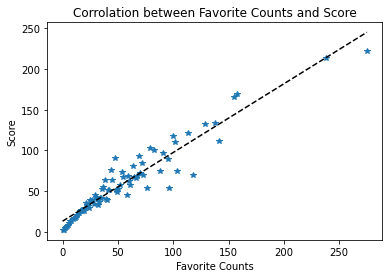

In [11]:
avg = defaultdict(lambda :{'count': 0, 'sum': 0})

# calculate the sum and count for each key
for k, v in data:
    avg[k]['count'] += 1
    avg[k]['sum'] += v

# calculate the average
result=[(k, v['sum']/v['count']) for k, v in avg.items()]
result.sort(key = lambda x: x[0])
Final_results=result
x_data = np.array([tup[0] for tup in Final_results])
y_data = np.array([tup[1] for tup in Final_results])
plt.plot(x_data, y_data,'*')
m, b = np.polyfit(x_data, y_data, 1)
plt.plot(x_data, m*x_data + b,'k--')
plt.xlabel('Favorite Counts')
plt.ylabel('Score')
plt.title("Corrolation between Favorite Counts and Score") 

In [12]:
corr, _ = pearsonr(x_data, y_data)
print("Pearson's correlation between Favorite Counts and Score of posts: %.3f" % corr)

Pearson's correlation between Favorite Counts and Score of posts: 0.955


As shown in the plot and based on the Pearson's correlation coefficient , there is a strong corrolation between the score of a psot and the number of times it was favorited by the users. Now, let's try to find the answer of the second question.

### 3.2.  Do the users with the highest reputation mainly post answers? or do they mainly post question posts?

Let's investigate the correlation between a user's reputation and the type of posts (Answers or Questions) they make. To this aim, I singled out posts which are either questions or answers for the 100 users with the highest reputation and looked at the percentage of these posts that are answers: *(answers / (answers + questions))*. 

In [13]:
## Creating RDDs of all valid posts
rows_post = sc.textFile(localpath('/spark-stats-data/allPosts/'))\
              .filter(lambda x: isrow(x))

In [14]:
## Functions to find the question and answer types of posts
def posttype(t,line):
    return ' PostTypeId="'+str(t)+'" ' in line
def postowner(x):
    start = x.find('OwnerUserId=')+13
    if start==12:
        return '0'
    a = x.find('" ParentId=')
    if a==-1:
        end = x.find('" PostTypeId=')
        return str(x[start:end])
    else:
        return str(x[start:a])
questions = rows_post.filter(lambda x: posttype(1,x)).map(lambda x:postowner(x))
answers = rows_post.filter(lambda x: posttype(2,x)).map(lambda x:postowner(x))
a_dic = answers.countByValue()
q_dic = questions.countByValue()

In [15]:
## Function to extract the reputation of the users
def user_rep(x):
    acc = str(x[x.find('" Id="')+6:x.find('" LastAccessDate=')])
   
    if x.find('Reputation="')==-1:
        return [acc,0]
    else:
        rep = int(x[x.find('Reputation="')+12:x.find('" UpVotes=')])
        return [acc,rep]
lines_user = sc.textFile(localpath('/spark-stats-data/allUsers/'))
rows_user=lines_user.filter(lambda x: isrow(x)) 
reputation = rows_user.map(user_rep)
reputation_user = reputation.map(lambda x:(x[1],x[0])).sortByKey(ascending=False)

Now, let's plot the histogram of Answer posts/(Answer posts + Question posts) for the 100 users with the highest reputation

Text(0, 0.5, 'Counts')

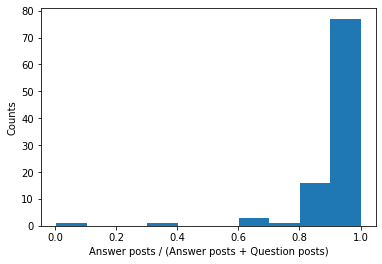

In [16]:
topusers = reputation_user.collect()[0:99]
output = []
for user in topusers:
    ID = int(user[1])
    q = q_dic[user[1]]
    a = a_dic[user[1]]
    if a+q==0:
        rate = 0
    else:
        rate = a*1.0/(a+q)
    output.append([ID,rate])
#
plt.hist([top[1] for top in output], bins=10)
plt.xlabel('Answer posts / (Answer posts + Question posts)')
plt.ylabel('Counts')

The plot of histogram clrealy shows that users with the highest reputations are mainly deidicated posting answers rather than posting questions!

### 3.3. Does the first question posted by users indicate their future behavior?

It is interesting to think about what factors influence a user to remain active on the website over a long period of time. In order not to bias the results towards older users, we'll define a time window between 100 and 150 days after account creation. If the user has made a post in this time, we'll consider them active and well on their way to being **veterans** of the site; if not, they are inactive and were likely **brief** users.


Let's see if there are differences between the **first ever question posts** of "veterans" vs. "brief users". Therefore, for each group we provide the follwoing: average score, views, number of answers, and number of favorites of the users' **first question**.


In [17]:
def isRow(line):
    return '<row' in line and '/>' in line

def get_allpost(line):
    root = etree.XML(line)
    ownerid, posttype, Id, Time, Score, ViewCount, AnsCount, FavCount = ('0',)*8
    if 'OwnerUserId' in root.attrib:
        ownerid = root.get('OwnerUserId')
        
    if 'PostTypeId' in root.attrib:
        posttype = root.get('PostTypeId')  
        
    if 'Id' in root.attrib:
        Id = root.get('Id')
    
    if 'CreationDate' in root.attrib: 
        Time = root.get('CreationDate')
        Time = datetime.strptime( Time.split('.')[0], "%Y-%m-%dT%H:%M:%S" )

    if 'Score' in root.attrib :
        Score = root.get('Score')
        
    if 'ViewCount' in root.attrib: 
        ViewCount = root.get('ViewCount')
        
    if 'AnswerCount' in root.attrib:   
        AnsCount = root.get('AnswerCount')

    if 'FavoriteCount' in root.attrib:
        FavCount = root.get('FavoriteCount')

    return (ownerid, (posttype, Id, Time, Score, ViewCount, AnsCount, FavCount))


def get_auser(line):
    root = etree.XML(line)
    if 'Id' in root.attrib and 'CreationDate' in root.attrib:
        Id = root.get('Id')   
        Time = root.get('CreationDate')
        Time = datetime.strptime( Time.split('.')[0], "%Y-%m-%dT%H:%M:%S" )
        return (Id, Time)
    else:
        return None

users = sc.textFile(localpath('spark-stats-data/allUsers/'))\
        .filter(isRow)\
        .map(get_auser)\
        .filter(lambda x: x is not None)

In [18]:
def test_Veteran(data):
    (x,y) = data
    if not y[1]:
        return None
    init_time = y[1]
    delta_time_list = []
    if not y[0]:
        return None
    for yy in y[0]:
        if not yy[2]:
            return None
        dt = yy[2] - init_time
        if dt.days >= 100 and dt.days <= 150 :
            return True
    return False
        
def earliest_question(data):
    (x, y) = data
    early = y[0]
    if len(y)>1:
        for yy in y[1:]:
            if yy[2] < early[2]:
                early = yy        
    return (x, early)

vets = sc.textFile(localpath('spark-stats-data/allPosts/'))\
        .filter(isRow)\
        .map(get_allpost)\
        .filter(lambda x: x is not None)\
        .map(lambda x: (x[0], [x[1],]))\
        .reduceByKey(lambda x, y: x + y)\
        .join(users)\
        .filter(lambda x: test_Veteran(x)==True)\
        .map(lambda x : (x[0], [yy for yy in x[1][0] if yy[0] =='1'] ) ) \
        .filter(lambda x: x[1]!=[])\
        .map(earliest_question)\
        .map(lambda x: (x[0], (x[1][3],x[1][4],x[1][5],x[1][6])))


briefs = sc.textFile(localpath('spark-stats-data/allPosts/'))\
        .filter(isRow)\
        .map(get_allpost)\
        .filter(lambda x: x is not None)\
        .map(lambda x: (x[0], [x[1],]))\
        .reduceByKey(lambda x, y: x + y)\
        .join(users)\
        .filter(lambda x: test_Veteran(x)==False)\
        .map(lambda x : (x[0], [yy for yy in x[1][0] if yy[0] =='1'] ) ) \
        .filter(lambda x: x[1]!=[])\
        .map(earliest_question)\
        .map(lambda x: (x[0], (x[1][3],x[1][4],x[1][5],x[1][6])))

In [19]:
vets_stat = vets.map(lambda x: ('1', (1, int(x[1][0]),int(x[1][1]),int(x[1][2]),int(x[1][3]))) )\
                .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3], x[4]+y[4]) )\
                .collect()

x,y = vets_stat[0]
print ([1.0*yy/y[0] for yy in y[1:] ])
vscore, vviews, vans, vfav = [1.0*yy/y[0] for yy in y[1:] ]


briefs_stat = briefs.map(lambda x: ('1', (1, int(x[1][0]),int(x[1][1]),int(x[1][2]),int(x[1][3]))) )\
                .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3], x[4]+y[4]) )\
                .collect()

x,y = briefs_stat[0]
print ([1.0*yy/y[0] for yy in y[1:] ])
bscore, bviews, bans, bfav = [1.0*yy/y[0] for yy in y[1:] ]

[3.5322843190450355, 927.7042864894195, 1.2962561041779708, 1.2930005425935973]
[2.100084697910785, 552.9672971955581, 0.9704968944099379, 0.5757105213626953]


| Group | Average Score | Views | Number of Answers | Number of Favorites |
| :-: | :-: | :-: | :-: | :-: |
| Veterans | 3.53 | 927.7 |  1.3 |  1.3  |
| Briefs | 2.10 | 553 |  0.97 |  0.57  |

Based on the results shown in the table, first ever question posts of veterans are more attractive compared to first ever question posts of briefis. This proofs the idea that the first question posted by users could be a sign for their future behavior.

# 4.Natural Language Processing


### Could natural language processing be used to predict the tags of a question from its body text?

I'd like to see if it's possible to predict the tags of a **question** from its body text. Instead of predicting specific tags, we will instead try to predict if a question contains one of the top ten most common tags. The application of the NLP is that when a user posts a questions without adding tags to the post, our model can predict what tags should be assigned to it, and later on these tags could be used to facilated the searching and finding the relevent information.

The tags of posts were extracted throught the following function that parses the XMLs and finds the "Tags" elements:

In [20]:
def get_tags(line):
    root = etree.XML(line)
    tags = []
    if 'Tags' in root.attrib: 
        Tag_str = root.get('Tags')
        tags = Tag_str.replace('&lt;', ' ').replace('&gt;', ' ').replace('<', ' ').replace('>', ' ').split()
    else:
        return None
    return tags
Num_tags_sorted=sc.textFile(localpath('spark-class-data/posts_train/'))\
                    .filter(lambda x: isrow(x))\
                    .map(get_tags)\
                    .filter(lambda x: x is not None)\
                    .flatMap(lambda doc: [(x, 1) for x in doc])\
                    .reduceByKey(lambda x, y: x+y)\
                    .map(lambda x: (x[1],x[0]))\
                    .sortByKey(ascending=False)
top_10_tagss=Num_tags_sorted.map(lambda x: x[1]).take(10)

**Text Cleaning:** Let's extract the body text of questions and then convert them to lower-case and and remove punctuations and non-alphabetic characters from the body text.

In [39]:
TAG_RE = re.compile(r'<[a-z/]+>')

mytag = top_10_tagss

def get_body(line):
    root = etree.XML(line)
    body = []
    if 'Body' in root.attrib: 
        body_str = root.get('Body')
        body_str = TAG_RE.sub('', body_str)
        body_str = re.sub(r'[?|!|\'|"|#]',r'',body_str)
        body_str = re.sub(r'[.|,|)|(|\|/]',r'',body_str)
        body_str= body_str.strip()
        body_str = body_str.replace('\n',' ').lower()        
    else:
        return None
        
    if 'Tags' in root.attrib: 
        Tag_str = root.get('Tags')
        tags = Tag_str.replace('&lt;', ' ').replace('&gt;', ' ').replace('<', ' ').replace('>', ' ').split()
        if any(item in tags for item in top_10_tagss):
            y = 1.0
        else:
            y = 0.0
    else:
        return None
    
    if 'Id' in root.attrib:
        Id = root.get('Id')  

    return (body_str, y, Id)

**Removing stopwords and Performing the word stemming:** I defined the `removeStopWords` fuction to removed all the stop-words present in the texts using the default set of stop-words that can be downloaded from NLTK library. I also added few stop-words to the standard list. Stop words are basically a set of commonly used words in any language, not just English. The reason why stop words are critical to many applications is that, if we remove the words that are very commonly used in a given language, we can focus on the important words instead.
Moreover, I defined the `stemming` function to perform stemming as well. There exist different kinds of stemming which basically transform words with roughly the same semantics to one standard form.

In [23]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
###
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

The spark `ml` package is based on DataFrames. So, it is required to convert RDDs into DataFrames for NLP tasks. A DataFrame is a distributed collection of data organized into named columns. DataFrames are an abstraction that lets us think of data in a familiar form (pandas `DataFrame`).

In [24]:
##Creating DataFrames of the training and test sets
sqlContext = SQLContext(sc)
##
training_set_all = sc.textFile(localpath('spark-class-data/posts_train/'))\
            .filter(isrow)\
            .map(get_body)\
            .filter(lambda x: x is not None)\
            .map(removeStopWords)\
            .filter(lambda x: x is not None)\
            .map(stemming)\
            .filter(lambda x: x is not None)\
            .toDF(['text', 'label'])

test_set_all = sc.textFile(localpath('spark-class-data/posts_test/'))\
            .filter(isrow)\
            .map(get_body)\
            .filter(lambda x: x is not None)\
            .map(removeStopWords)\
            .filter(lambda x: x is not None)\
            .map(stemming)\
            .filter(lambda x: x is not None)\
            .toDF(['text', 'label'])

**Tokenization and Vectorization:** Now it's required to create the `Transformers` and `Estimators` for the training.  I used two `Transformers`, a `Tokenizer` to tokenize the words and then a `HashingTF` to hash these words into a feature matrix (effectively a word count with a hash function).  Lastly, I used a `LogisticRegression` `Estimator` to perform the logistic regression classification.  

Each of these `ML` objects take both an `inputCol` and an `outputCol` keyword argument (they have reasonably sane defaults).  When their transform method is called, they take the input `DataFrame` and produce a `DataFrame` which has the extra column `outputCol` with the relevant transformation applied to `inputCol`.

In [26]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
logreg = LogisticRegression(maxIter=5, regParam=0.1)

tokens = tokenizer.transform(training_set_all)
hashes = hashingTF.transform(tokens)
model = logreg.fit(hashes)

Now we can make predictions on our test data.  Note that we do need to perform the same transformations in the same order we did on training data before we can call the `transform` method of the fitted model.  Once we get a prediction, we can select out the particular columns of the `DataFrame` we care about.

In [32]:
# Make predictions on test documents
test_tokens = tokenizer.transform(test_set_all)
test_hashes = hashingTF.transform(test_tokens)

prediction = model.transform(test_hashes)
selected = prediction.select("probability", "label", "prediction")
prediction.select(["features", "probability", "prediction","label"]).show(5)

+--------------------+--------------------+----------+-----+
|            features|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|(262144,[3564,607...|[0.35592194672787...|       1.0|  1.0|
|(262144,[3798,735...|[0.00369985056426...|       1.0|  1.0|
|(262144,[2574,649...|[0.71439648450096...|       0.0|  1.0|
|(262144,[3889,124...|[0.18483876172208...|       1.0|  1.0|
|(262144,[3564,762...|[0.47566664424752...|       1.0|  1.0|
+--------------------+--------------------+----------+-----+
only showing top 5 rows



In [37]:
# compute accuracy on the test set
result = model.transform(test_hashes)
predictionAndLabels = result.select("prediction", "label")
evaluator = BinaryClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.8623809523809523


The accuracy of the model on the test data is good, but let's see if we can improve the accuracy by tunning the hyperparameters of the model.

### Hyperparameters Optimization

Tuning hyperparameters through cross validation is necessary for the most performant models. While doing this grid search by hand is not difficult, there is a perfectly good high level model already built in. We can use a ParamGridBuild object to build a grid to search over. Each Transformer has a number of hyperparameters we can tune, and we can add a grid for as few or as many of these as we would like. The hyperparameters were the reglarization factor of the  logistic regression model and the number of features in HashingTF.

In [41]:
pipeline = Pipeline(stages=[tokenizer, hashingTF, logreg])
paramGrid = (ParamGridBuilder() 
    .addGrid(hashingTF.numFeatures, [1000,8000,20000,40000]) 
    .addGrid(logreg.regParam, [1,0.5,0.1,0.05,0.001])
    .build())

In [42]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [43]:
cvModel = crossval.fit(training_set_all)

Now, let's look at the best parameters found:

In [44]:
best_run = np.array(cvModel.avgMetrics).argmin()
paramGrid[best_run]

{Param(parent='HashingTF_6eac42a3eaf2', name='numFeatures', doc='Number of features. Should be greater than 0.'): 40000,
 Param(parent='LogisticRegression_8e0c90c00257', name='regParam', doc='regularization parameter (>= 0).'): 0.001}

In [45]:
best_prediction = cvModel.bestModel.transform(test_set_all)
selected = best_prediction.select("probability", "label", "prediction")

In [46]:
# compute accuracy on the test set
predictionAndLabels = best_prediction.select("prediction", "label")
evaluator = BinaryClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.9601609723309426


Awesome! We could achive 96 % accuracy through optimizing the hyperparameters of the model!